In [107]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = { # thresh=0.1
0.2:[0.574137882739,0.117924053771],
0.4:[0.516598893174,0.0517583826384],
0.8:[0.34328828939,0.0357882812154],
1.2:[0.288284913923,0.0232571237128],
1.6:[0.284424366299,0.0325989118031],
2.0:[0.245942817302,0.0164289592739],
}

def ddy(y,f):
    ny = np.size(f)
    df = np.zeros(ny)
    dy = y[1]-y[0]
    #for j in range(1,ny-1): df[j] = (f[j+1]-f[j-1])/(2*dy)
    for j in range(2,ny-2): df[j] = (-f[j+2]+f[j+1]-f[j-1]+f[j+2])/(12.*dy)
    return df

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    d = {}
    d['R11'] = dat[:,0]
    d['R12'] = dat[:,1]
    d['R22'] = dat[:,3]  
    return d#R11,R12,R22

def get_data(f):
    dat = np.fromfile(f,sep=' ')
    n = np.size(dat)
    dat = np.reshape(dat,[int(n/6.),6])
    ubar = dat[:,0]
    vbar = dat[:,1]
    utilde = dat[:,2]
    vtilde = dat[:,3]
    ru = dat[:,4]
    rv = dat[:,5]
    return ubar,vbar,utilde,vtilde,ru,rv

directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*production*")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['shearlayer_production_0000.dat', 'shearlayer_production_0001.dat', 'shearlayer_production_0003.dat', 'shearlayer_production_0004.dat', 'shearlayer_production_0005.dat', 'shearlayer_production_0012.dat', 'shearlayer_production_0013.dat', 'shearlayer_production_0014.dat', 'shearlayer_production_0015.dat', 'shearlayer_production_0016.dat', 'shearlayer_production_0017.dat', 'shearlayer_production_0018.dat', 'shearlayer_production_0019.dat', 'shearlayer_production_0020.dat', 'shearlayer_production_0101.dat', 'shearlayer_production_0102.dat', 'shearlayer_production_0103.dat', 'shearlayer_production_0104.dat', 'shearlayer_production_0105.dat', 'shearlayer_production_0106.dat', 'shearlayer_production_0107.dat', 'shearlayer_production_0108.dat', 'shearlayer_production_0109.dat', 'shearlayer_production_0110.dat', 'shearlayer_production_0111.dat', 'shearlayer_production_0112.dat'

0.2: [0.122518619095,0.028868538236],
0.4: [0.211269887525,0.00640637180369],
0.8: [0.188443401767,0.0278830777178],
1.2: [0.218497559511,0.00855344046322],
1.6: [0.205110308217,0.027979163661],
2.0: [0.207098877612,0.0116296335157],


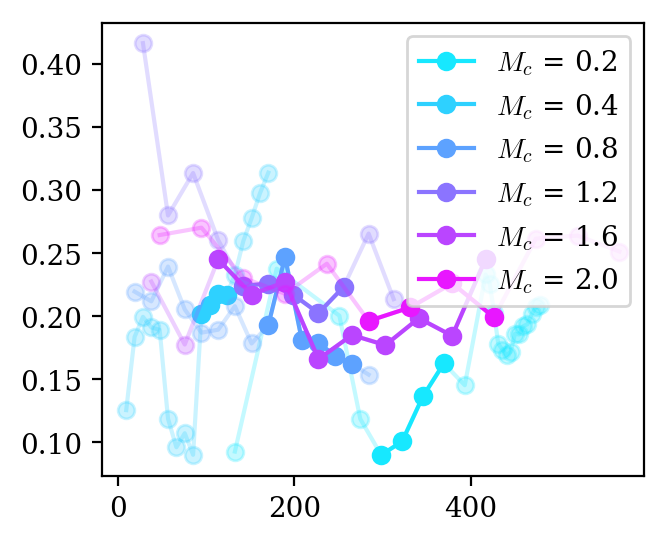

In [111]:
# Scaling using U_delta
s = '1'
# Mc_list = ['08',]#['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


fig = plt.figure(figsize=(3.5,3),dpi=200)
for i,Mc in enumerate(Mc_list):
    if Mc is '04':# or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    directory = dir_out
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
     
    
    flist = glob.glob(directory+"*production*")
    flist.sort()
    flist = flist[1:]

    if Mc=='02': ist=5;ien=9;flist=flist[2:] # mira run
    #if Mc=='02': ist=-8;ien=-4 # theta run
    #elif Mc=='04': ist=8;ien=14 #mira run
    elif Mc=='04': ist=-9;ien=-5 #theta run
    elif Mc=='08': ist=9;ien=-1
    elif Mc=='12': ist=5;ien=-2
    elif Mc=='16': ist=3;ien=None
    elif Mc=='20': ist=6;ien=-3;
    else: ist=0; ien=None 
        
    colorVal = scalarMap.to_rgba(inp.Mc)
    mat = np.zeros([2,len(flist)])
    for j,fname in enumerate(flist):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]
        eta = y/dtheta

        # Get Production
        Pii = np.fromfile(fname,sep=' ')
        
        # Get utilde and dudy
        scaling='udelta3'
        if scaling=='du3':
            utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
            L99,i1,i2 = get_L99(-y,utilde)
            scale = L99/inp.du**3
        elif scaling=='udelta3':
            # Get lscale y
            autocorr = np.fromfile(directory+'/lscale_vv_%04d.dat'%(tID),sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.1)
            scale = ly/(du[inp.Mc][0]*inp.du)**3
        fplot = Pii*scale
        #if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
        #else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)#label='%s'%fname)#
        mat[0,j] = time*inp.du
        mat[1,j] = abs(1./dtheta * integrate_y(y,fplot))
        if scaling=='growth':
            mat[1,j] = abs(2./inp.du**2 * integrate_y(y,Pii))

    isort = np.argsort(mat[0,:])
    mat[0,:] = mat[0,isort]
    mat[1,:] = mat[1,isort]
    plt.plot(mat[0,1:]-mat[0,0],mat[1,1:],'-o',alpha=0.25,color=colorVal)
    plt.plot(mat[0,ist:ien]-mat[0,0],mat[1,ist:ien],'-o',color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
    print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[1,ist:ien]),np.std(mat[1,ist:ien])))

plt.legend(fontsize=10)